# Costa Rican Household Poverty Level Prediction

[참고] https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough#Costa-Rican-Household-Poverty-Level-Prediction

## Problem and Data Explanation
멀티 클래스 지도학습 문제(This is a supervised multi-class classification machine learning problem):
* Supervised: provided with the labels for the training data
* Multi-class classification: Label은 4개의 class들로 이루어져 있음.(1~4)

### data info
* Target 값은 가난의 정도를 나타냄
    * 1 = extreme poverty 
    * 2 = moderate poverty 
    * 3 = vulnerable households 
    * 4 = non vulnerable households

* 일부 column 설명
* Id: a unique identifier for each individual, this should not be a feature that we use!
* idhogar: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.
* parentesco1: indicates if this person is the head of the household.
* Target: the label, which should be equal for all members in a household

### what I learned
* enumerate 함수 :
    * 순서가 있는 자료형(list, set, tuple, dictionary, string)을 입력으로 받아 인덱스 값을 포함하는 enumearte객체를 리턴한다.
* collections.OrderedDict 함수 :
    * 순서대로 저장된 사전형이 필요한 경우 
    * 사전형(dict)는 내부의 자료값만 같으면 동일하다고 판단하지만, 순서를 기억하는 사전형(orderedDict)은 내부의 자료값 뿐만 아니라 입력된 순서까지 같아야 동일한 것으로 판단.
* 함수로 Target이 1,2,3,4 일때 각각의 ked-plot그리는 방법 , 각 Target별 다른 컬러 지정.
* 문자와 숫자가 혼재되어있는 데이터의 경우, 문자를 조건에 따라 특정 숫자로 변경할 때
    * 예를들어, yes:1, no:0으로 바꿀 경우 -> replace({"yes":1, "no":0}) 와 같이 작성 가능
* subplot 에서 각 인자의 의미 :
    * subplot(3,1,1)이면 3행 1열의 1번째 plot
* groupby와 apply함수 동시 사용 : unique한 값이 한개만 있는 Target을 idhogar별로 그룹핑
    * train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
* nunique() 와 unique()의 차이 
    * nunique()는 unique한 값의 개수
* for,if 문 한줄로 함께 사용 & startswith 함수
    * [x for x in data if x.startswith('tipo')] 
* corr()를 통해 상관계수 구한것에서 위 삼각형 부분 값만 불러오는 법
    * corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
* any()함수 :
    * Iteration이 가능한 객체를 받아 그 항목을 돌면서 어느 하나라도 True이면 결과로 True를 리턴. 
    * all() 함수는 반대로 모두 참이어야 참임.
* iterrows() 함수 : <br>
(참고) : https://3months.tistory.com/419
    * 행에 반복적으로 접근 하면서 그 값을 조작해야 할 경우 사용. 
    * 예를들어, A,B,C,D 컬럼 각각 값이 1일경우 순서대로 0,1,2,3 을 할당하고 싶을 때 
    * 또는, missing value가 0으로 코딩되어 있는데, 이를 nan으로 바꾸고 싶을 때 
* groupby한 값을 동시에 normalize해서 보고 싶을 때
    * heads.groupby('area1')['Target'].value_counts(normalize = True)
* boolean값 (0,1)을 가진 ordinal값에 argmax()로 하나의 컬럼으로 통합 :
    * bad, regular, good라는 세개의 컬럼이 있고 각컬럼 값이 0 또는 1일때 argmax()함수로 bad=0, regular=1, good=2로 매핑가능
* 피어슨, 스피어만 상관계수 


### missing value 처리 방법
* missing value가 많은 컬럼 외에 이와 연관이 있을법한 다른 컬럼 하나를 찾아서, null값일 때의 다른 컬럼값과 null값이 아닐때의 다른 컬럼 값을 비교해본다.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


#### integer columns
* 정수값을 가진 컬럼에서 unique한 값 카운팅

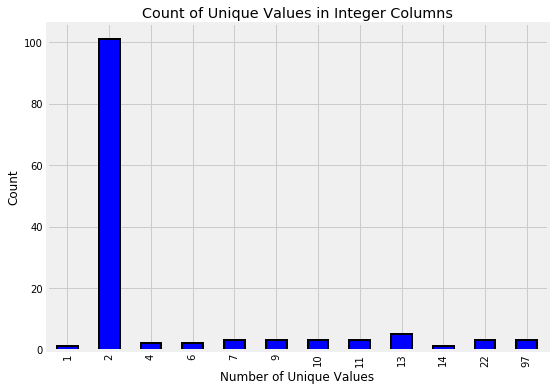

In [15]:
# integer형태인 컬럼의 해당 integer 유니크한 값 카운트 
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue', figsize=(8,6), edgecolor='k', linewidth=2)
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');
plt.show()

0과 1 값을 갖고 있는 컬럼이 가장 많다. 대다수의 경우, 이러한 boolean정보는 이미 household level안에 속해있다.  <br>
예를들어, 'refrig'컬럼은 가정에 냉장고가 있는지 여부 (0,1)이다.

#### float columns
OrderedDict 함수로 poverty level과 컬러를 매핑 시킬것이다. 왜냐하면, 이것은 key와 value로 가져갈수 있기 때문에. (보통의 python dictionary와는 다름) <br>
가난의 정도에 따라 (1~4) 컬러를 다르게 매핑하여, 가난의 정도 마다 분포에 차이가 있는지를 확인하기 위함.

In [27]:
# enumerate 함수 결과예시
data = enumerate(train.select_dtypes('float'))
for i, value in data:
    print(i, ":", value)
print()

0 : v2a1
1 : v18q1
2 : rez_esc
3 : meaneduc
4 : overcrowding
5 : SQBovercrowding
6 : SQBdependency
7 : SQBmeaned



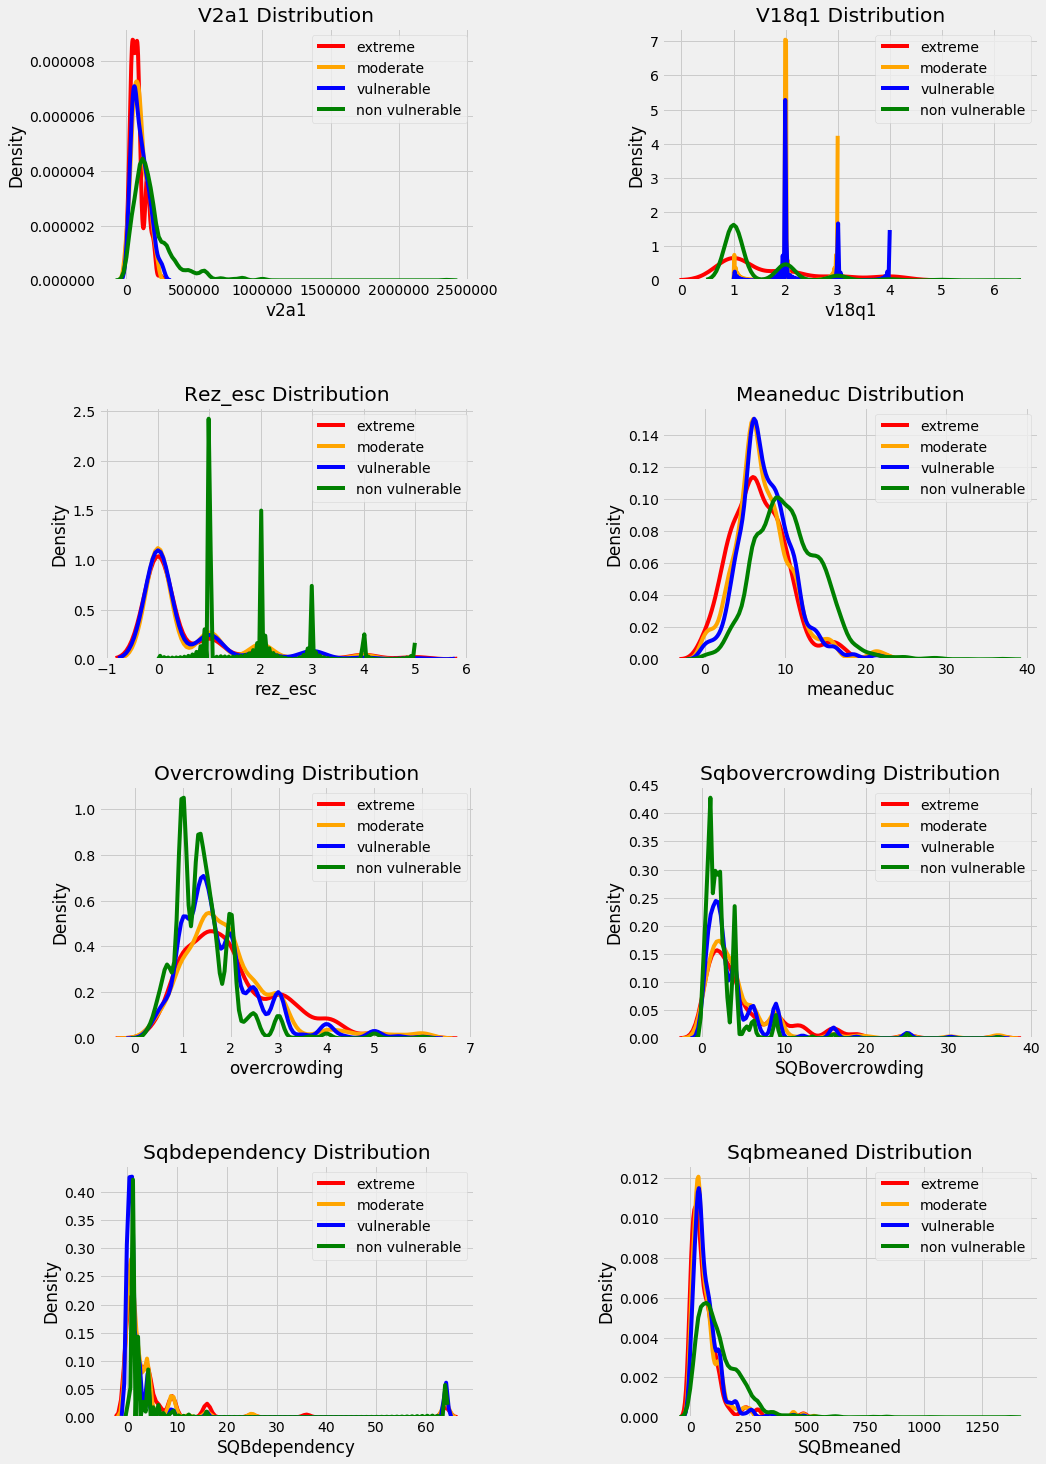

In [57]:
from collections import OrderedDict

plt.figure(figsize = (15, 10))
plt.style.use('fivethirtyeight')

# Color mapping
### OrderedDict는 값을 순서대로 저장.
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
### 여기서 i는 0,1,2,3~7 까지의 index값이고 'col'은 float값을 가진 컬럼 값
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    
    # Iterate through the poverty levels
    ### poerty_level은 1,2,3,4 값이고 color는 'red','orange'...
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(wspace = 0.5, hspace = 0.5) 
plt.subplots_adjust(top = 2)

추후에 변수와 Target간의 상관관계를 계산할 것이지만, 이 plot에서 이미 어떤 변수들이 가장 연관성이 있는지를 알 수 있다. <br>
'meaneduc'변수의 경우 성인들의 평균 교육은 poverty level과 관련이 있는것을 볼 수 있다 .<br>
성인 평균 교육이 높을 수록, poverty level이 덜 심각한것을 알 수 있음. 즉, 가난할수록 교육이 열악하다

#### Object Columns

In [66]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Id, idhogar를 제외한 다른 컬럼들은 문자와 숫자 값이 혼재되어 있어 처리가 필요하다. 
* dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
* edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
* edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0 <br>

위 세개 변수의 경우, yes=1, no=0 이므로 string값을 숫자로 바꿀 수 있음.

In [75]:
mapping = {"yes":1, "no":0}

for df in [train,test]:
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa']=df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe']=df['edjefe'].replace(mapping).astype(np.float64)
    
train[['dependency','edjefa','edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [99]:
for i, col in enumerate(['dependency','edfefa','edfefe']):
    print(i, ":", col)
print()

0 : dependency
1 : edfefa
2 : edfefe



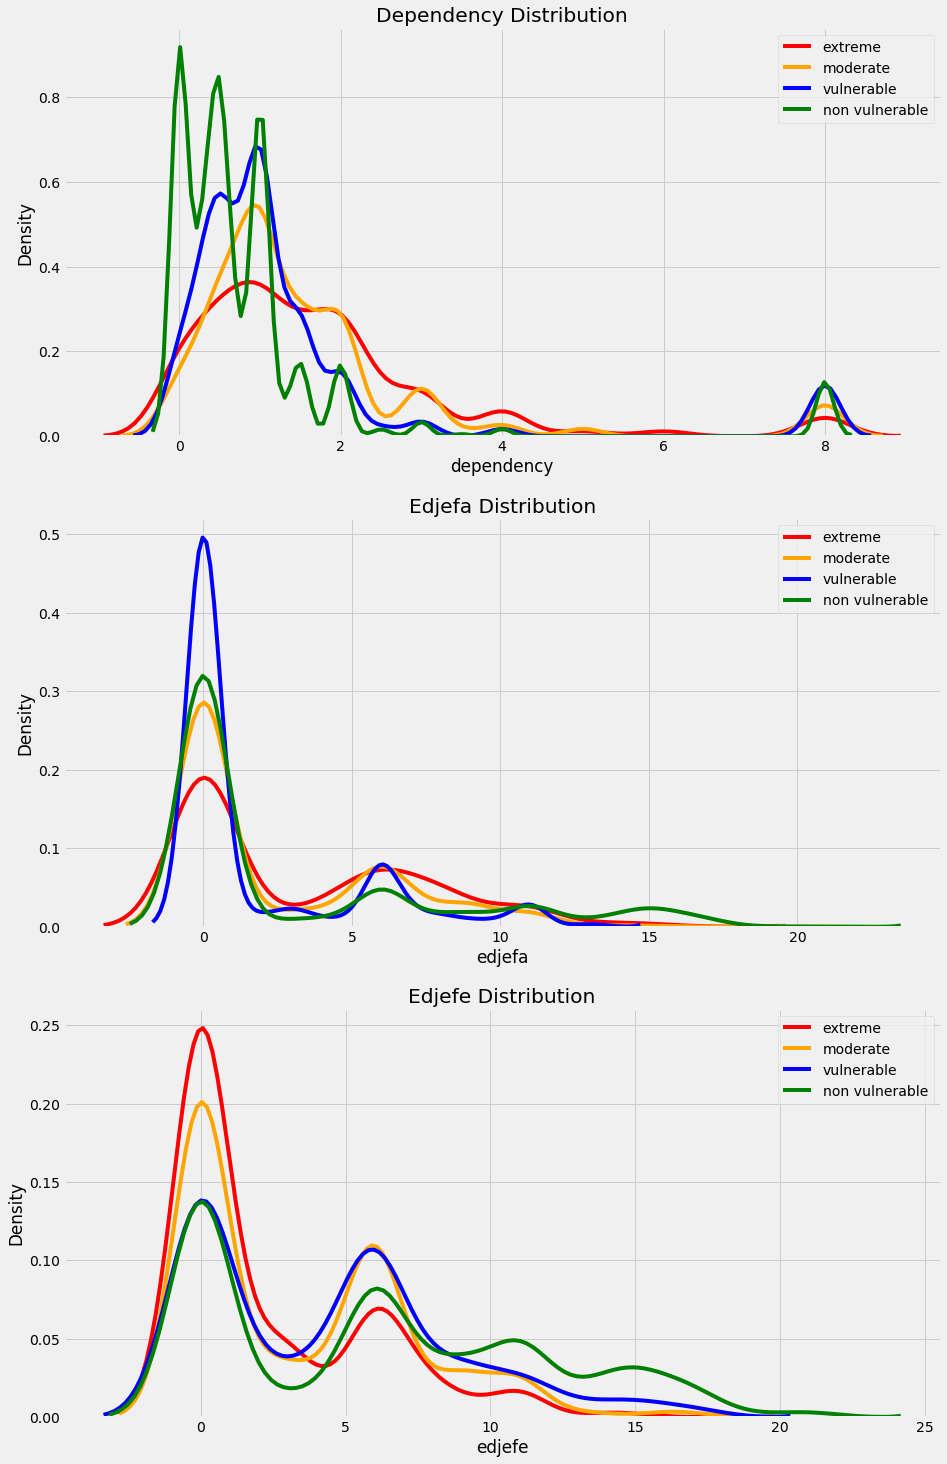

In [113]:
plt.figure(figsize=(14,10))

for i, col in enumerate(['dependency','edjefa','edjefe']):
    ax=plt.subplot(3,1,i+1)
    for poverty_level, color in colors.items():
        sns.kdeplot(train[col][train['Target']==poverty_level].dropna(), 
                   ax=ax, color=color, label=poverty_mapping[poverty_level])
        # train.loc[train['Target']==poverty_level, col] 로 해도 동일
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
                                                              
plt.subplots_adjust(top=2)

training 데이터와 testing 데이터 프레임을 join할것이다. train데이터와 test데이터에 동일한 feature engineering을 진행할 것이기 때문에. <br>
이후에 Target을 바탕으로 두 set을 분리시키면 된다.

In [114]:
# test데이터에 Null값인 'Target' 컬럼을 추가
test['Target'] = np.nan
data = train.append(test, ignore_index=True)   # append하면 train데이터 아래로 test데이터가 붙음.

### Exploring Label Distribution
label의 분포를 확인해 봄으로써, 문제가 얼마나 불균형한지 알수있다는 아이디어를 얻었다. <br>
여기에는 가난의 정도를 가르키는 4개의 가능한 integer level이 있다. <br>
정확한 label을 보기 위해, 우리는 parentesco1 ==1 인 컬럼만 볼것이다. 왜냐하면 이것은 head of household이기 때문이다. 

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

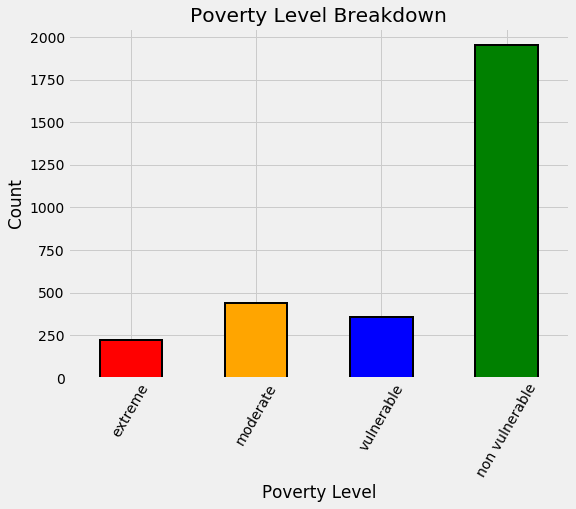

In [150]:
# parentesco1 가 1인 것들만 copy
heads = data.loc[data['parentesco1']==1].copy()

# training데이터의 label
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1']==1), ['Target','idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize=(8,6), color=colors.values(), edgecolor='k', linewidth=2)

plt.xlabel('Poverty Level'); plt.ylabel('Count')
plt.xticks(ticks=[x-1 for x in poverty_mapping.keys()], labels=list(poverty_mapping.values()), rotation=60)
#plt.xticks([0,1,2,3],['extreme', 'moderate', 'vulnerable', 'non vulnerable'])
plt.title('Poverty Level Breakdown');

label_counts

우리는 imbalanced class problem 을 다루고 있다. 다른 카테고리보다 non vulnerable 로 분류된 가정이 매우 많은것을 볼 수 있다. <br>
extreme 클래스가 가장 적다. <br>
imbalanced classification problem의 문제는 머신러닝 모델은 어떤 클래스가 샘플이 매우 적으면 예측하는데 어려움을 겪는다. <br>
이를 해결할 한가지 방법은 oversampling이다. 

### Addressing Wrong Labels
이 문제에서 몇몇 label은 정확하지 않을 것이다. 왜냐하면 같은 가정에서 각 개인은 다른 poverty level을 갖고 있기 때문이다. <br>
그래서 head of household 를 true label로 사용해야 할 것이다.

#### Identify Errors
다른 label을 갖고 있는 가정을 찾기 위해서는, 데이터를 household로 그룹핑한다. 그리고 Target값이 한개의 unique한 값만 있는지 확인한다.

In [159]:
# unique한 값의 개수가 1개인 (poverty level이 한종류만 있는 값만)
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)  #unique는 unique한 값의 개수

# 한 household에 target이 여러개 있는 (같지 않은) 가정
not_equal = all_equal[all_equal!= True]

print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [163]:
train[train['idhogar']==not_equal.index[0]][['idhogar','parentesco1','Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


정확한 label이려면 parentesco1 ==1 일때, 모든 멤버의 label이 3이어야 한다. <br>
우리는 이것을 정확한 poverty level로 reassigning할수있다. 

#### Families without Heads of Household
만약 head of household 가 없는 가정이라면 ? 혹은 가정의 멤버들의 label이 다른 가치를 갖고있다면 ?

In [189]:
# idhogar로 그룹핑 했을 때, parentesco1 합계
households_leader=train.groupby('idhogar')['parentesco1'].sum()

# isin()은 TRUE, FALSE값 반환
### idhogar로 그룹핑했을 때, parentesco1이 0인 것들의 인덱스를 행으로
households_no_head=train.loc[train['idhogar'].isin(households_leader[households_leader==0].index),:]

print('There are {} households without a head'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head


In [203]:
households_no_head_equal=households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal==False)))

0 Households with no head have different labels.


위 결과, 가장이 없는 가정에서 멤버들이 다른 label을 갖는 경우는 없다는 것을 알 수 있다. <br>
그러므로, 우리는 가장이 없는 가정은 training에 쓰지 않을 것이다. 

#### Correct Errors
가장이 있고, 구성원들이 다른 poverty level을 갖고 있는 가정의 경우 우리는 label을 고칠 수 있다. 

In [212]:
for household in not_equal.index:
    # 각 idhogar별로 가장이 있을 때(parentesco1==1) 의 target값이 정확한 label임.
    true_target = int(train[(train['idhogar']==household) &(train['parentesco1']==1.0)]['Target'])
    
    # household에 모든 member들의 label을 위에서 구한 true_target으로 바꾼다.
    train.loc[train['idhogar']==household,'Target'] = true_target
    
# household를 idhogar별로 그룹핑하고 unique한 'Target'값이 한개인 경우 True
all_equal = train.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)

# Target이 False인 경우
not_equal = all_equal[all_equal!=True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


### Missing Variables
각 컬럼에서의 missing value percentage를 확인하자.

In [218]:
# 0이라는 컬럼명을 'total' 로 변경
missing=pd.DataFrame(data.isnull().sum()).rename(columns={0:'total'})

# Create a percentage missing
missing['percent'] = missing['total']/len(data)

missing.sort_values('percent', ascending=False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


Target컬럼은 test데이터에 NaN값을 넣어줬기 때문에 신경쓸 필요 없다. 그러나 그 외에 상위 3개의 컬럼에 대해서는 고민해볼 필요 있음. <br>
* v18q1: 가정에서 소유한 테블릿 대수

In [223]:
# heads 변수는 가장인 경우만 가져온 데이터 (parentesco1==1)
def plot_value_counts(df, col, heads_only=False):
    """컬럼의 value를 count한것, 가정의 가장들 위주로"""
    if heads_only:
        df = df.loc[df['parentesco1']==1].copy()
    
    plt.figure(figsize=(8,6))
    df[col].value_counts().sort_index().plot.bar(color='blue', edgecolor='k', linewidth=2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts');plt.ylabel('Count')
    plt.show();

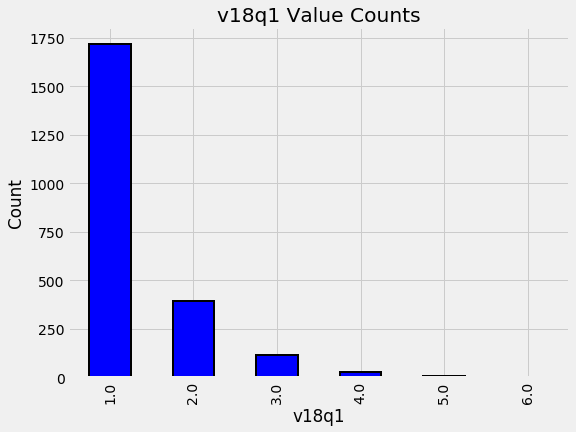

In [224]:
plot_value_counts(heads,'v18q1')

대부분 태블릿을 1대 가지고 있는 경우가 가장 많다. 그러나 우리는 missing 데이터에 대해서 고민해봐야 한다 .이경우에 nan이 있는 가정은 태블릿을 소유하고있지 않는다! <br> 
데이터 설명을 보면, v18q 컬럼은 가족이 태블릿을 소유하고 있는지, 아닌지를 나타낸다 .<br>
우리는 우리의 가정을 지지하기 위해, 태블릿 숫자와 이 컬럼을 결합해서 조사해야한다 . 

In [233]:
# nan값들의 태블릿 소유 여부 (0,1) 별 태블릿 대수 
heads.groupby('v18q')['v18q1'].apply(lambda x : x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

* v18q1이 nan인 family는 태블릿을 소유하고 있지 않는다는것을 확인 했으므로, missing value를 모두 0으로 채울 수 있다. 

In [235]:
data['v18q1'] = data['v18q1'].fillna(0)

다음으로 missing value percentage가 높은 컬럼 -> v2a1
* v2a1: Monthly rent payment (월별 렌트 지불비용) <br>

월별 렌트비용을 살펴보기 전에, 집의 ownership/renting상태를 보여주는 'tipovivi_' 의 분포를 보는것도 의미가 있을 것이다. <br>


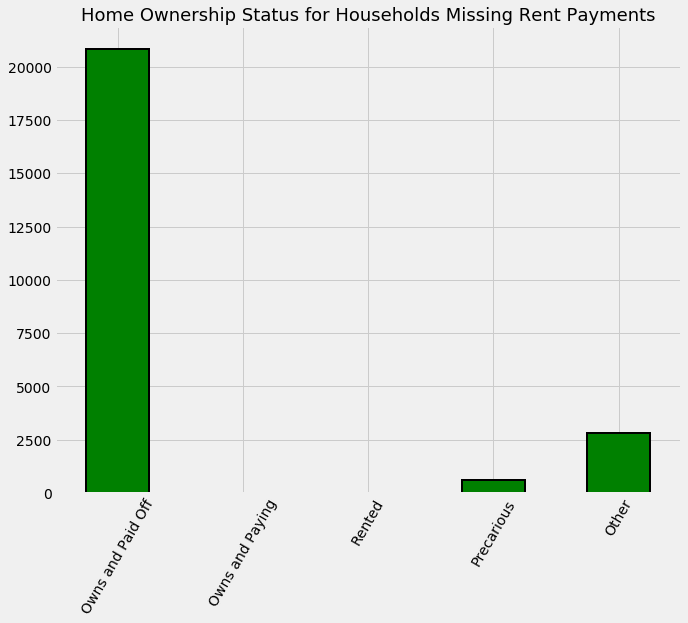

In [249]:
# home owenership을 나타내는 변수
own_variables=[x for x in data if x.startswith('tipo')]

# 렌트 지불비용이 nan인 것들의 ownership/renting상태를 보여주는 tipovivi_컬럼
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize=(10,8), color='green', edgecolor='k', linewidth=2)

plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

각각의 의미
* tipovivi1, =1 own and fully paid house
* tipovivi2, "=1 own,  paying in installments"
* tipovivi3, =1 rented
* tipovivi4, =1 precarious
* tipovivi5, "=1 other(assigned,  borrowed)"

=> 따라서,  v2a1 컬럼이 nan인 (즉, 월별 rent payment가 없는) 가정은 대부분 그들의 자가인 경우가 많다.  <br>
그러므로 자가이면서 monthly rent payment가 missing value인 경우는 rent payment값을 0으로 바꾸겠다. <br>
다른 경우에는 missing value가 대체되도록 그냥 둘것이나, 이 household가 missing value라는것을 나타내는 Boolean 컬럼을 추가할것이다. 

In [252]:
# 자기 집을 보유한 household의 rent payment는 0으로 대체
data.loc[(data['tipovivi1']==1), 'v2a1'] =0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()
data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

* rez_esc: years behind in school <br>
null 값이 있는 가족은 아마도 현재 학교를 다니는 아이들이 없다는 의미일 수 있다. <br>
age 컬럼을 통해서 rez_esc가 null값인 것들의 age와 null값이 아닌 것들의 age를 확인해보자.

In [260]:
# rez_esc컬럼이 null이 아닌것들의 age컬럼
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

rez_esc가 null값인 것들의 age를 봤을 때, 최대값이 17인것으로 보아 17살보다 나이가 많은 사람은 학교에 있지 않을 것이다. <br>
null값인 것들의 나이를 확인해보자.

In [261]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

이 competition의 discussion에서 이 변수는 7살에서 19살까지만 정의되는 것으로 확인했다. <br>
따라서, 만약 개인이 19살보다 많고 missing value일 경우 또는 만약 7살보다 어리고 missing value가 있을 경우 , 우리는 0으로 바꾸겠다.

In [262]:
# rez_esc값이 null이고, age가 19보다 크거나 또는 rez_esc값이 null이고, age 가 7보다 작으면 rez_esc값은 0으로 대입
data.loc[((data['age']>19) | (data['age']<7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# 나이가 7살~19살인 값들에는 표시를 해준다.
data['rez_esc-missing'] = data['rez_esc'].isnull()

rez_esc컬럼에는 outlier도 있다. competition discussion 에서 , 이 변수의 최대값은 5라고 나와있다. 그러므로, 5보다 큰 값들은 5로 변경.

In [266]:
data.loc[data['rez_esc']>5, 'rez_esc']=5

## Plot Two Categorical Variables
두 범주형 변수 시각화

In [289]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

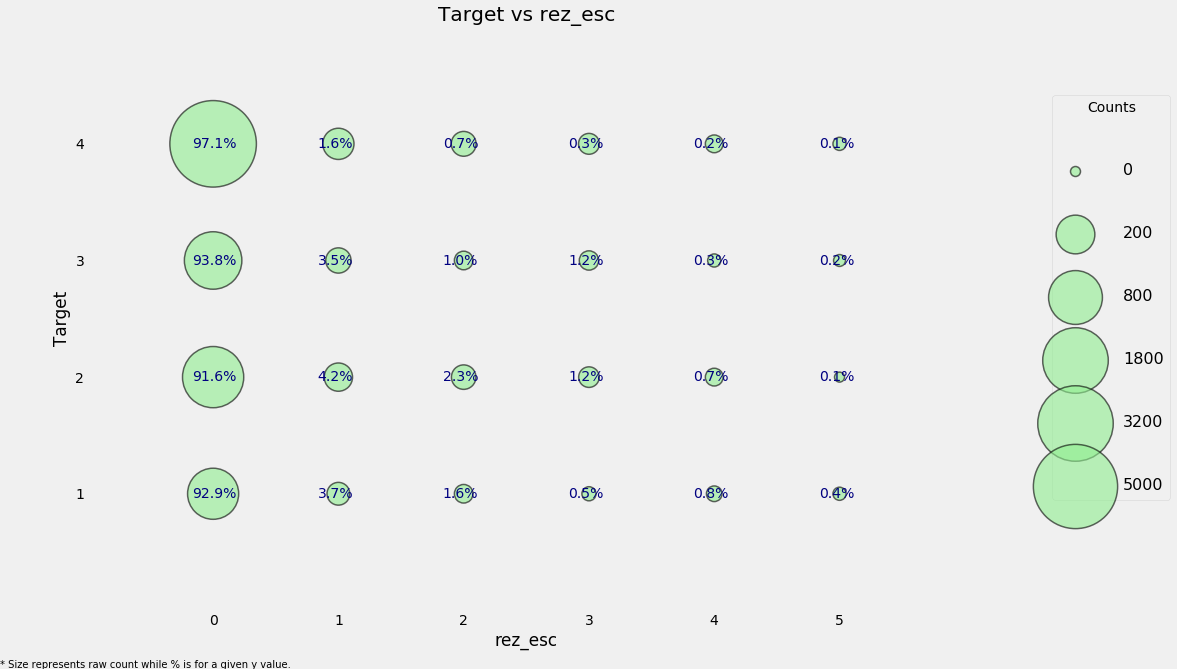

In [290]:
plot_categoricals('rez_esc', 'Target', data);

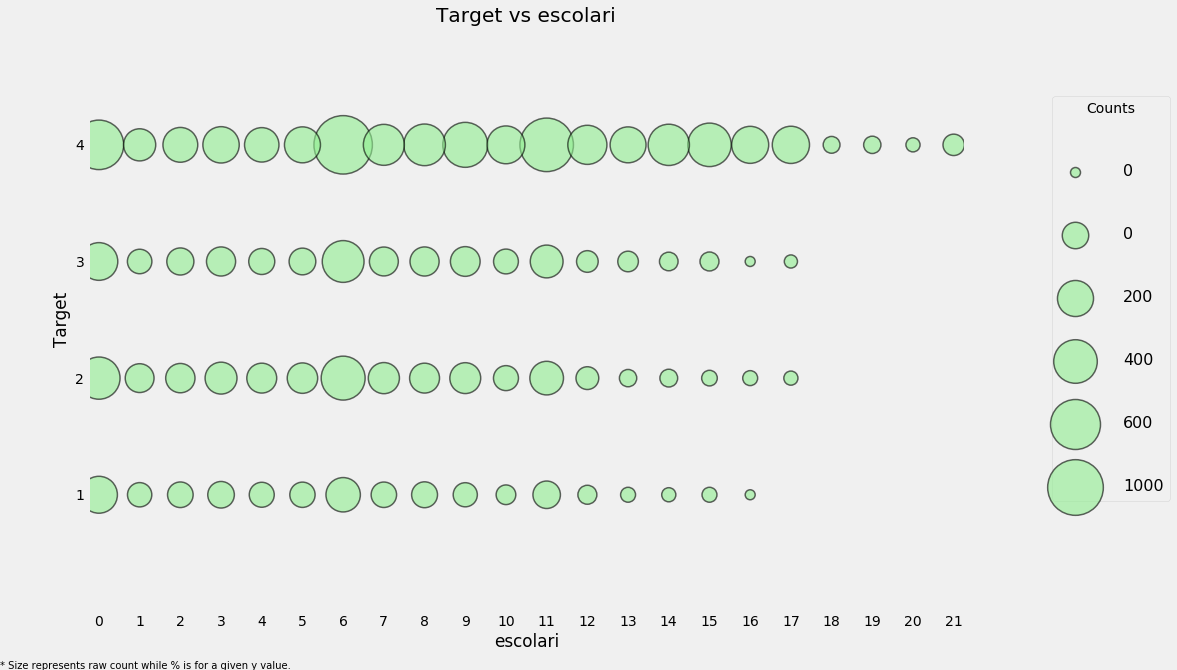

In [291]:
plot_categoricals('escolari', 'Target', data, annotate = False)

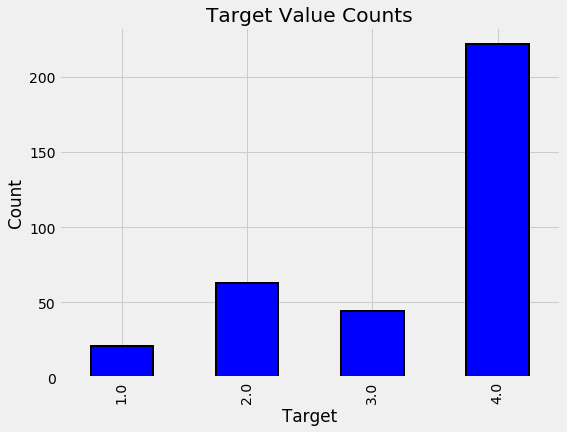

In [298]:
# 1이면 True, 0이면 False
### years behind school값이 null인 경우는 나이가 7살보다 어리거나, 19살보다 많은 경우
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 
                  'Target')

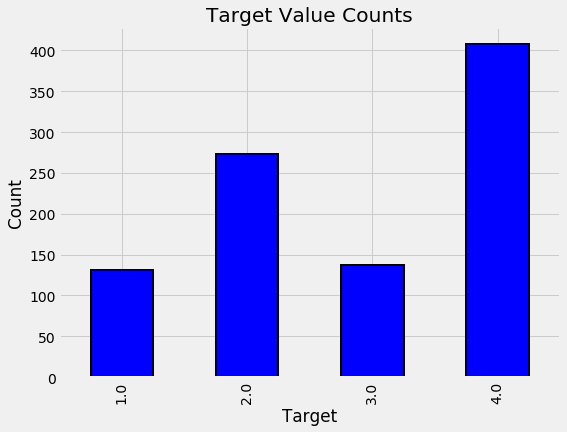

In [303]:
# v2a1이 null이란것은 집이 자기 소유라는 의미
plot_value_counts(data[(data['v2a1-missing'] == 1)], 
                  'Target')

위 결과를 통해 missing information이 주어진 정보보다 더 중요할때도 있다는것을 알수있다.

## Feature Engineering
grouping , aggregation 작업

#### Column Definitions
process
* 변수들을 household level 과 individual level로 나눈다.
* individual level 데이터에 대해서 적절한 aggregation를 찾는다.
* individual aggregation 을 household level 데이터로 join한다. 

#### Define Variable Categories
변수들에 몇가지 다른 카테고리가 있다. <br>
1. Individual Variables: these are characteristics of each individual rather than the household
    * Boolean: Yes or No (0 or 1)
    * Ordered Discrete: Integers with an ordering
2. Household variables
    * Boolean: Yes or No
    * Ordered Discrete: Integers with an ordering
    * Continuous numeric
3. Squared Variables: derived from squaring variables in the data
4. Id variables: identifies the data and should not be used as features

In [309]:
id_ = ['Id', 'idhogar', 'Target']

In [310]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [311]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [312]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [326]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_
from collections import Counter

print('There are no repeats: ', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

There are no repeats:  True
We covered every variable:  True


#### Squared Variables
SQBage 와 age 컬럼의 관계를 살펴보자.

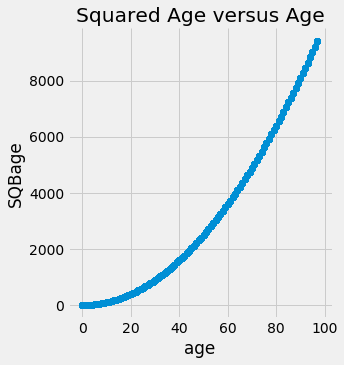

In [332]:
sns.lmplot('age', 'SQBage', data = data, fit_reg=False);
plt.title('Squared Age versus Age');

이 두 변수는 correlated가 높으므로, 둘다 가져갈 필요는 없어보인다.

In [339]:
# squared 변수 (제곱항 변수) 제거
data = data.drop(columns=sqr_)
data.shape

(33413, 136)

#### Id Variables
These are pretty simple: they will be kept as is in the data since we need them for identification

#### Household Level Variables
First let's subset to the heads of household and then to the household level variables.

In [341]:
# 가장인 경우만 heads 변수에 저장.
heads = data.loc[data['parentesco1']==1,:]
# 위에서 정의한 컬럼들만 heads변수에 저장
heads = heads[id_ + hh_bool+hh_cont+hh_ordered]
heads.shape

(10307, 99)

우리는 이러한 변수들을 feature로 사용할 것이다. 그러나, 불필요한 변수들은 제거할 것이고 또한 현재 갖고있는 데이터로부터 더 많은 feature들을 추가할 것이다.

#### Redundant Household Variables
모든 household 변수들 간의 상관관계를 볼것이다. 만약 상관관계가 너무 큰것이 있으면, 둘중 하나는 제거할지도 모른다.

In [372]:
corr_matrix = heads.corr()

# np.triu()는 위의 삼각형값만 가져오도록. k=1은 대각선 값 취급안하고 가져옴.
## astype(np.bool) 은 True, False값으로 반환.
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# 상관계수 절대값이 0.95보다 큰 컬럼이 하나라도 있는경우
to_drop = [column for column in upper.columns if any(abs(upper[column])>0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

위 변수들은 상관계수 한짝임. 나머지 한짝을 찾아내보자.

In [379]:
# 행과 열 모두에서 'tamhog' 변수값이 0.9보다 큰 경우 
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


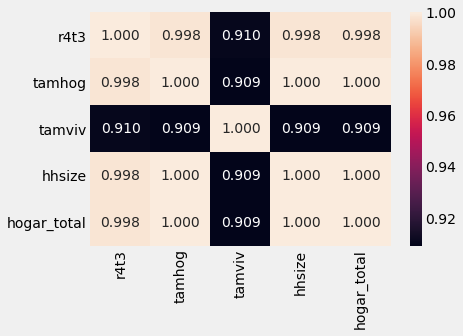

In [382]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9], annot=True, fmt='.3f');

관련 변수 info
* r4t3 : Total persons in the household (가정에 총 사람 수)
* tamhog : size of the household (가정의 크기)
* tamviv : number of persons living in the household (가정에 살고있는 사람 수)
* hhsize : household size (가정의 크기)
* hogar_total: # of total individuals in the household (가정의 개개인 수?)

결과를 보면, hhsize 변수는 tamhog변수와 hogar_total변수와 완벽하게 상관관계가 있다 . 우리는 이 두 변수를 제거할것이다.<br>
또한 우리는 r4t3 변수도 제거할것이다. 왜냐하면, hhsize변수와 거의 완벽히 상관관계가 있기 때문에. <br>

tamviv변수는 hhsize변수 만큼 완전 똑같진 않다. 왜냐하면 가족 구성원중에 집에 살고있지 않은 사람도 있을 수 있기 때문에. <br>
시각화를 통해 더 알아보자.

In [387]:
heads = heads.drop(columns=['tamhog','hogar_total','r4t3'])

/data2/home/suhyuncho/.conda/envs/suhyun2/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


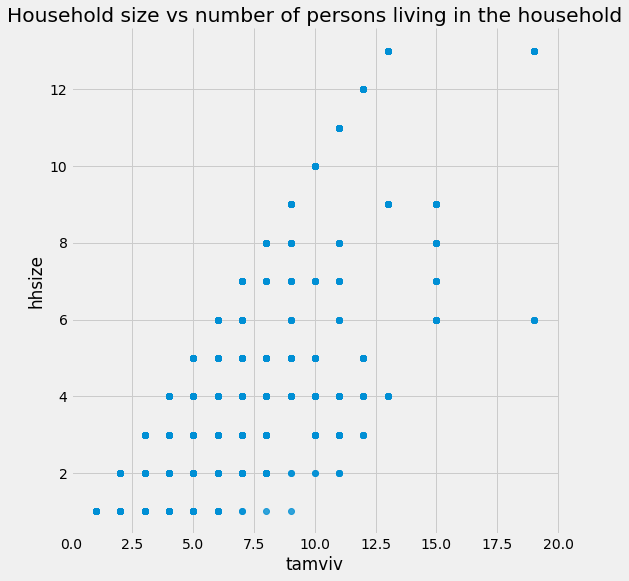

In [388]:
sns.lmplot('tamviv','hhsize', data, fit_reg=False, size=8);
plt.title('Household size vs number of persons living in the household');

household에 살고있는 사람들이 family에 있는거보다 많다. 이것은 새로운 feature에 대한 좋은 정보를 준다. 이 두 measurements 의 차이!

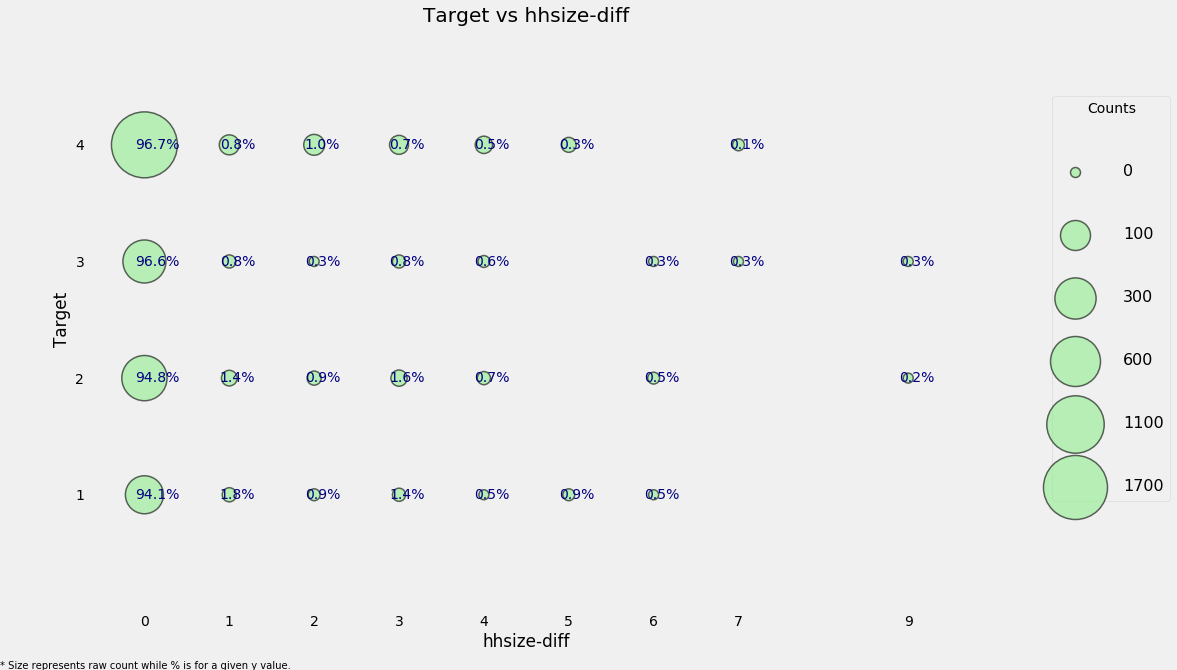

In [389]:
heads['hhsize-diff']=heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

모든 household가 차이가 있는건 아니지만, household의 member보다 살고있는 사람들이 더 많은 경우가 몇 있다.<br>
이제 또 다른 불필요한 변수들을 살펴보자. 우선 coopele변수 를 살펴보자.

In [390]:
corr_matrix.loc[corr_matrix['coopele'].abs() >0.9, corr_matrix['coopele'].abs()>0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


이 변수는 집에 전기를 어디로부터 받느냐 하는 변수이다. 4개의 option이 있다. <br>
noelec 는 no electricity 이고, planpri 는 private plant로부터 받는다는것임.

#### Creating Ordinal Variable
ordinal 변수를 만듬으로써, 이 네개의 변수를 하나로 압축시키겠다. 각 숫자로 의미에 따라 mapping시킴.
* 0: No electricity
* 1: Electricity from cooperative
* 2: Electricity from CNFL, ICA, ESPH/JASEC
* 3: Electricity from private plant

값이 0인 household는 nan으로 채우겠다. 그리고 여기에 값이 없었다는 것을 표기하기 위해 Boolean 컬럼을 추가할것이다. 

In [405]:
elec =[]

# 각 컬럼을 돌아가면서 값이 1이면 elec변수에 값을 할당
for i, row in heads.iterrows():
    if row['noelec']==1:
        elec.append(0)
    elif row['coopele']==1:
        elec.append(1)
    elif row['public']==1:
        elec.append(2)
    elif row['planpri']==1:
        elec.append(3)
    else:
        elec.append(np.nan)

# elec 변수 새로 추가
heads['elec']=elec

# nan인 값인지 아닌지 남기기위해 새로운 컬럼 추가 
heads['elec-missing']=heads['elec'].isnull()         # null값이면 True

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

In [408]:
heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

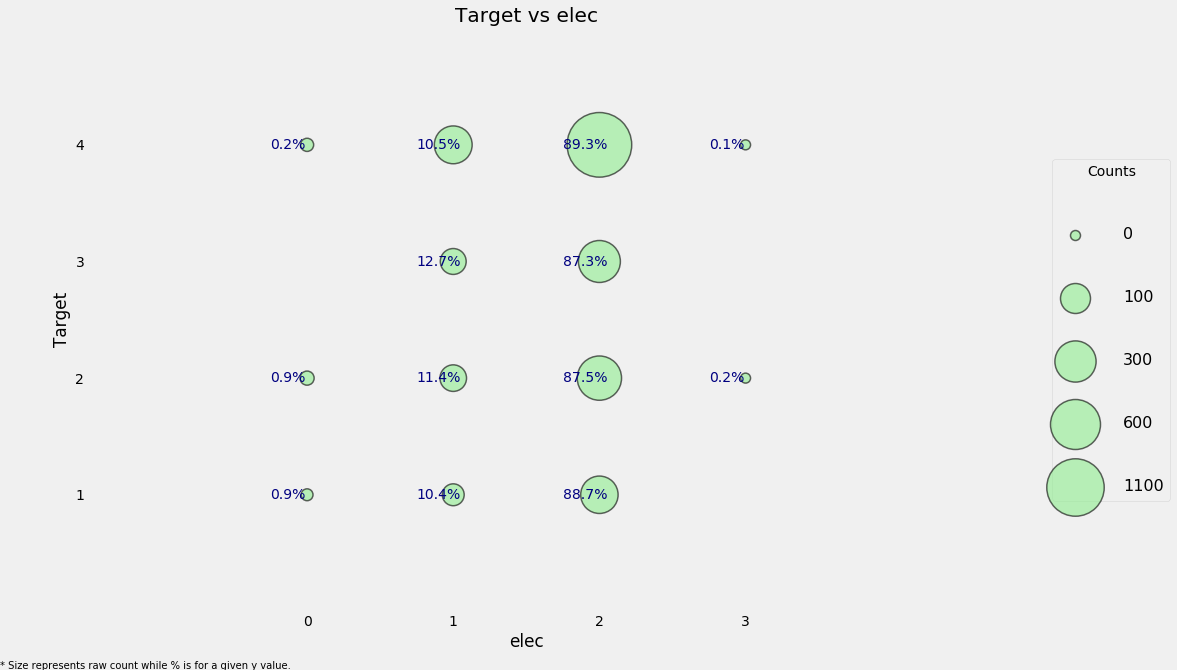

In [407]:
plot_categoricals('elec','Target', heads)

listed providers 로 부터 오는 electricity 가 가장 많다는 것을 확인.

이제 불필요한 컬럼 area2 를 살펴보자. 이 변수는 집이 시골에 있는지 여부를 나타낸다. <br>
그러나 우리는 집이 도시에 있는지를 나타내는 컬럼(area1)이 있기 때문에 이는 불필요하므로 삭제

In [413]:
heads = heads.drop(columns='area2')
heads.groupby('area1')['Target'].value_counts(normalize=True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

도시지역에 있는 가정이 시골에 있는 가정보다 poverty level이 낮을 경우가 더 많다는 것을 알 수 있다. <br>
즉, 도시에 사는 사람들이 덜 가난하다..

#### Creating Ordinal Variables
집의 벽, 지붕, 바닥에 관해 세개의 컬럼이 있다. 첫번째는 'bad'를 가르키고, 두번째는 'regular, 세번째는 'good'를 가르킨다. <br>
이 변수들을 그냥 boolean값으로 둘수도있지만, ordinal 변수로 바꾸는게 더 나아보인다. <br>
왜냐하면 bad < regular < good 이라는 순서가 내재되어 있기 때문에. 이렇게 하면, 어떤 컬럼이 non-zero인지 np.argmax를통해 알 수 있다. <br>
* np.argmax(a,axis=1) axis가 1일경우 y축 기준 : axis에 해당하는 값들 중 가장 큰 값의 인덱스를 반환하는 함수
    * 아래의 경우는 epared1가 1이면 0, epared2가 1이면 1, epared3가 1이면 2

In [422]:
heads[['epared1', 'epared2', 'epared3']].head()

,epared1,epared2,epared3
0,0,1,0
1,0,1,0
2,0,1,0
5,0,0,1
8,1,0,0


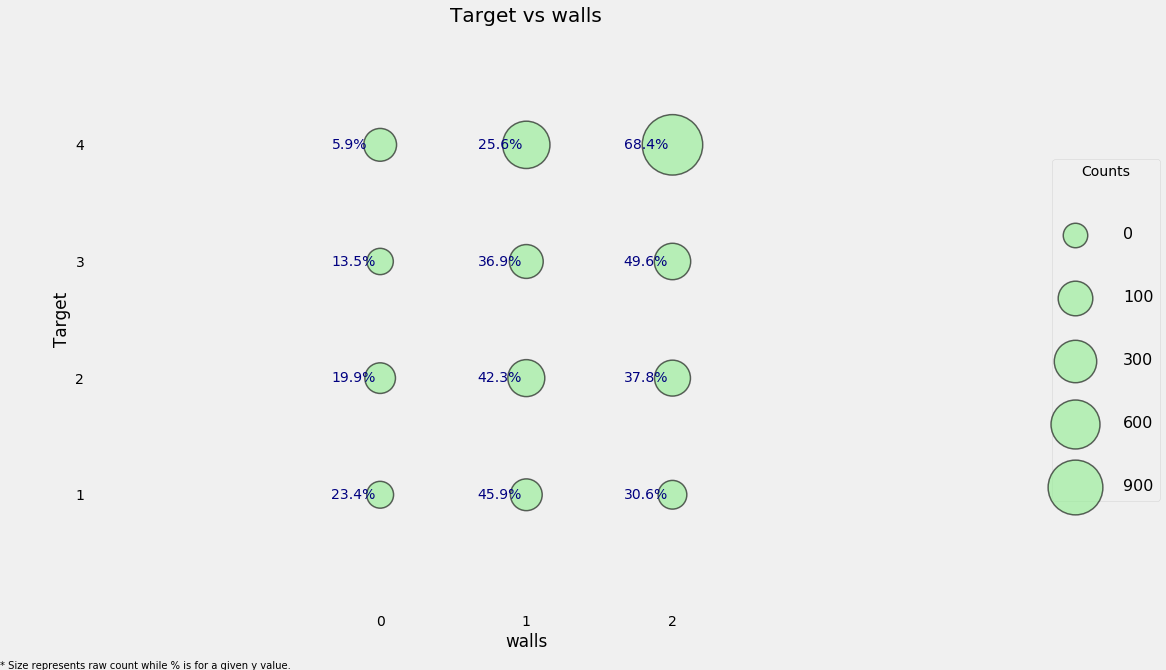

In [423]:
# Wall ordinal variable
heads['walls']=np.argmax(np.array(heads[['epared1','epared2','epared3']]),axis=1)
heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
plot_categoricals('walls','Target', heads)

In [426]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1','etecho2','etecho3']]), 
                          axis=1)
heads = heads.drop(columns=['etecho1','etecho2','etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

#### Feature Construction
우리는 기존 데이터로부터 완전히 새로운 feature를 만들수있는데, 이것이 흔히 말하는 feature construction 이다. <br>
전반적인 house's structure의 quality를 위해 이전의 세개의 feature들을 더해볼 수 있다.

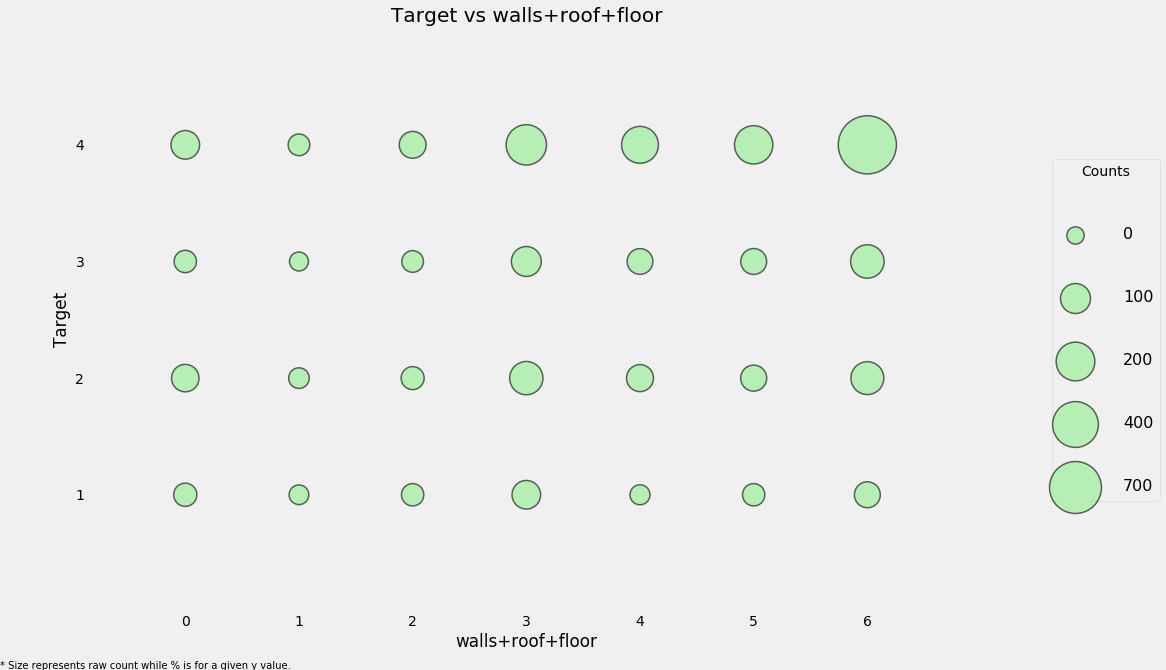

In [429]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']
plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

In [440]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


다음 변수는 house의 quality에 대한 warning이 될것이다. 이것은 -1인 음수값일 것이며, no toilet, electricity, floor, water service, and ceiling 에 대한 것이다.

In [456]:
# No toilet, no electricity, no floor, no water service, no ceiling
### True, False로 나오는 Boolean값에 1을 곱하면 숫자로 변환됨. (False=0, True=1)
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

warning 변수 숫자가 크면클수록 위험한것

In [474]:
(heads['elec'] == 0).head()

0    False
1    False
2    False
5    False
8    False
Name: elec, dtype: bool

In [475]:
1*(heads['elec'] == 0).head()

0    0
1    0
2    0
5    0
8    0
Name: elec, dtype: int64

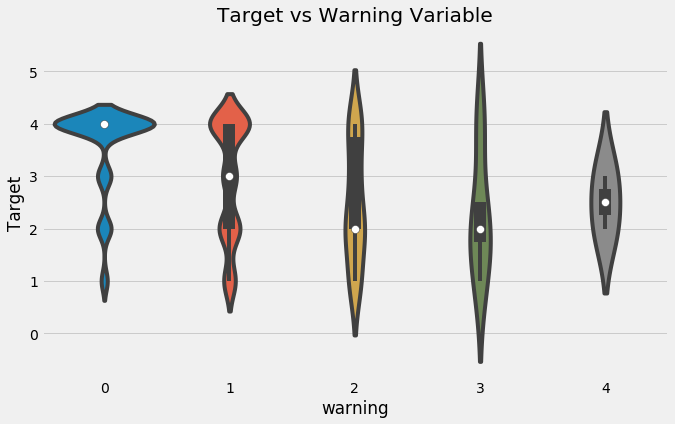

In [477]:
plt.figure(figsize=(10,6))
sns.violinplot(x='warning', y='Target', data=heads);
plt.title('Target vs Warning Variable');

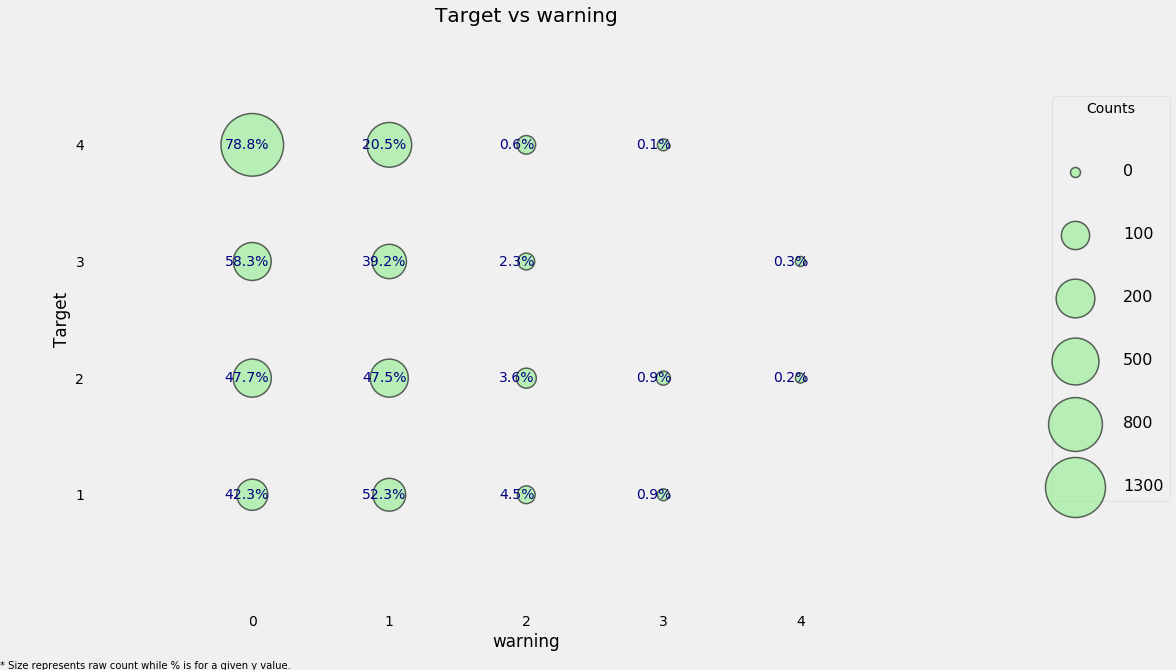

In [478]:
plot_categoricals('warning', 'Target', data = heads)

위 결과 warning sign이 없는 가정이 많다는 것을 알 수 있고, poverty수준도 낮다는것을 알 수 있다. 

마지막 household feature는 'bonus'인데, 이것은 가족이 냉장고, 컴퓨터, 태블릿, 또는 tv를 샀을때 받은 포인트이다.

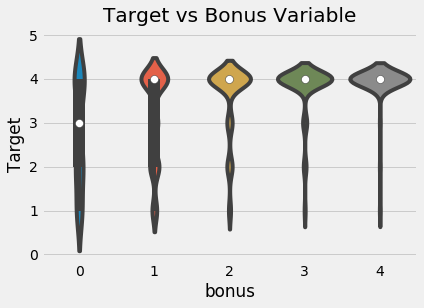

In [482]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])
sns.violinplot('bonus','Target', data=heads, figsize=(10,6))
plt.title('Target vs Bonus Variable');

#### Per Capita Features
household에서 사람 당 특정 measurements 대수를 계산한 feature를 추가할수있다. <br>
* tamviv : 가정에 살고있는 사람 수

In [487]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

### Exploring Household Variables
이제, Target과의 연관성을 보려고 한다. 이전에 조금 했었지만, 이제는 그 관계를 quantify(수량화) 하려고 한다.

#### Measuring Relationships 
피어슨 상관계수와 스피어만 상관계수 두가지가 있다.
1. 피어슨(The Pearson Correlation): from -1 to 1 measuring the linear relationship between two variables
    * 분석하고자 하는 두 변수가 모두 연속형 자료일 때 두 변수간 선형적인 상관 관계의 크기를 모수적인 방법으로 나타내는 값.
2. 스피어만(The Spearman Correlation): from -1 to 1 measuring the monotonic relationship between two variables
    * 상관 관계를 분석하고자 하는 두 연속형 변수의 분포가 심각하게 정규분포를 벗어난다거나, 또는 두 변수가 순위척도 자료일때 사용하는 값.
    * ex) 어떤 고등학교 3학년 학생들의 모의고사 성적을 각 과목별로 등수로 매겼을 때, 언어영역의 등수와 수리영역의 등수가 서로 상관 관계가 있는지 알아볼 때.
    * 스피어만 상관계수는 피어슨 상관계수와 달리, 선형적인 상관 관계를 나타내지 않고, 단순히 한 변수가 증가할 때 다른 변수가 증가하는지 감소하는지에 대한 관계만을 나타낸다. 

In [488]:
from scipy.stats import spearmanr

In [524]:
def plot_corrs(x, y):
    """Plot data and show the spearman and pearson correlation."""
    
    # Calculate correlations
    spr = spearmanr(x, y).correlation
    pcr = np.corrcoef(x, y)[0, 1]      # 2x2행렬에서 0행 1열 값
    
    # Scatter plot
    ### 상관관계를 확인할 두 컬럼을 하나의 데이터프레임으로 만들어줌
    data = pd.DataFrame({'x': x, 'y': y})
    plt.figure( figsize = (6, 4))
    sns.regplot('x', 'y', data = data, fit_reg = False);
    plt.title(f'Spearman: {round(spr, 2)}; Pearson: {round(pcr, 2)}');

In [516]:
pd.DataFrame({'x': x, 'y': y}).head()

,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16


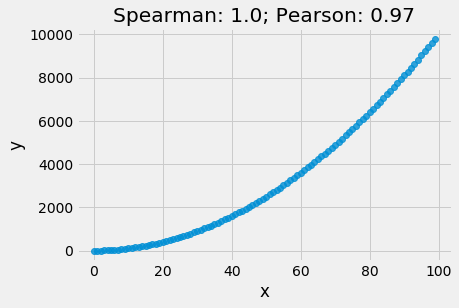

In [525]:
x = np.array(range(100))
y = x ** 2

plot_corrs(x,y)

Spearman 상관관계가 Target과 같은 ordinal variables 에는 더 낫다. <br>
대부분 실제 상황에서는 선형관계가 아니기 때문에, 그리고 Pearson 상관관계는 정확하지 않기 때문에 Spearman이 낫다.

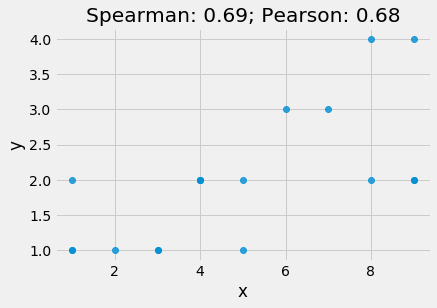

In [528]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

plot_corrs(x, y)

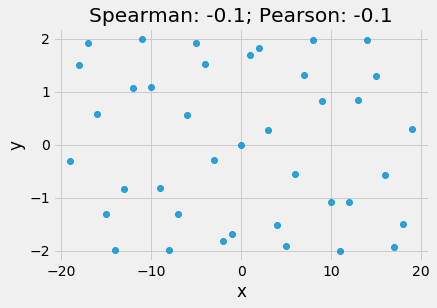

In [529]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

plot_corrs(x, y)